In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_float
from skimage.restoration import denoise_wavelet, denoise_tv_chambolle, denoise_nl_means
from skimage.metrics import peak_signal_noise_ratio
from scipy.ndimage import median_filter, gaussian_filter
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from skimage.transform import resize
import glob

In [2]:
image_paths = ["input.png", "2.jpeg", "input1.jpeg"]
dataset_dir = "E:\Denoising\data\Dataset"

images = []
resized_images = []
target_shape = None

for path in image_paths:
    image = io.imread(path, as_gray=True)
    image = img_as_float(image)
    images.append(image)

    if target_shape is None:
        target_shape = image.shape
    else:
        target_shape = (min(target_shape[0], image.shape[0]), min(target_shape[1], image.shape[1]))

    resized_image = resize(image, target_shape)
    resized_images.append(resized_image)

# Add noise to the resized images

In [3]:
noise_std = 0.1
noisy_images = [resized_image + noise_std * np.random.randn(*resized_image.shape) for resized_image in resized_images]


# Initialize denoised image lists

In [4]:
denoised_wavelet_all = []
denoised_tv_all = []
denoised_nlmeans_all = []
denoised_median_all = []
denoised_gaussian_all = []
denoised_autoencoder_all = []

# Autoencoder Denoising

In [5]:
input_img = Input(shape=target_shape + (1,))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Load and preprocess the images from the dataset

In [6]:
image_paths_large = glob.glob(dataset_dir + "/*.png") + glob.glob(dataset_dir + "/*.jpg")+glob.glob(dataset_dir + "/*.JPEG")

images_large = []
resized_images_large = []

for path_large in image_paths_large:
    image_large = io.imread(path_large, as_gray=True)
    image_large = img_as_float(image_large)

    # Resize image to match target shape
    resized_image_large = resize(image_large, target_shape)
    resized_images_large.append(resized_image_large)

    images_large.append(image_large)

# Add noise to the images from the dataset

In [7]:
noisy_images_large = [image_large + noise_std * np.random.randn(*image_large.shape) for image_large in resized_images_large]

# Reshape and normalize the images for prediction

In [8]:
resized_images_reshaped_large = np.array([np.expand_dims(image_large, axis=-1) for image_large in resized_images_large])
noisy_images_reshaped_large = np.array([np.expand_dims(image_large, axis=-1) for image_large in noisy_images_large])


# Train the autoencoder 

In [9]:
autoencoder.fit(noisy_images_reshaped_large, resized_images_reshaped_large,epochs=10,batch_size=10)
num_runs = 5


Epoch 1/10
14/14 [==============================] - 62s 4s/step - loss: 0.0496
Epoch 2/10
14/14 [==============================] - 56s 4s/step - loss: 0.0126
Epoch 3/10
14/14 [==============================] - 54s 4s/step - loss: 0.0045
Epoch 4/10
14/14 [==============================] - 56s 4s/step - loss: 0.0032
Epoch 5/10
14/14 [==============================] - 60s 4s/step - loss: 0.0025
Epoch 6/10
14/14 [==============================] - 58s 4s/step - loss: 0.0022
Epoch 7/10
14/14 [==============================] - 58s 4s/step - loss: 0.0021
Epoch 8/10
14/14 [==============================] - 58s 4s/step - loss: 0.0023
Epoch 9/10
14/14 [==============================] - 58s 4s/step - loss: 0.0023
Epoch 10/10
14/14 [==============================] - 57s 4s/step - loss: 0.0022


# Denoising the resized images using various methods

In [10]:


for _ in range(num_runs - 1):
    # Add noise to the resized images
    noisy_images = [resized_image + noise_std * np.random.randn(*resized_image.shape) for resized_image in resized_images]
    noisy_images_reshaped = np.array([np.expand_dims(image_large, axis=-1) for image_large in noisy_images])
    # Wavelet Denoising
    denoised_wavelet = [denoise_wavelet(noisy_image, wavelet='db4', mode='soft', method='BayesShrink', rescale_sigma=True)
                        for noisy_image in noisy_images]
    denoised_wavelet_all.append(denoised_wavelet)

    # Total Variation Denoising
    denoised_tv = [denoise_tv_chambolle(noisy_image, weight=1.0) for noisy_image in noisy_images]
    denoised_tv_all.append(denoised_tv)

    # Non-local Means Denoising
    denoised_nlmeans = [denoise_nl_means(noisy_image, h=0.1, sigma=1.5, fast_mode=True) for noisy_image in noisy_images]
    denoised_nlmeans_all.append(denoised_nlmeans)

    # Median Filter Denoising
    denoised_median = [median_filter(noisy_image, size=3) for noisy_image in noisy_images]
    denoised_median_all.append(denoised_median)

    # Gaussian Filter Denoising
    denoised_gaussian = [gaussian_filter(noisy_image, sigma=0.5) for noisy_image in noisy_images]
    denoised_gaussian_all.append(denoised_gaussian)

    
     
    # Autoencoder Denoising
    denoised_autoencoder = autoencoder.predict(noisy_images_reshaped)
    denoised_autoencoder_all.append(denoised_autoencoder)

1/1 [==============================] - 0s 282ms/step


# Calculating the PSNR for each denoising method:

In [11]:
psnr_wavelet_all = [[peak_signal_noise_ratio(resized_image.astype(np.float64), denoised.astype(np.float64))
                     for resized_image, denoised in zip(resized_images, denoised_wavelet_iter)]
                    for denoised_wavelet_iter in denoised_wavelet_all]

psnr_tv_all = [[peak_signal_noise_ratio(resized_image.astype(np.float64), denoised.astype(np.float64))
                for resized_image, denoised in zip(resized_images, denoised_tv_iter)]
               for denoised_tv_iter in denoised_tv_all]

psnr_nlmeans_all = [[peak_signal_noise_ratio(resized_image.astype(np.float64), denoised.astype(np.float64))
                     for resized_image, denoised in zip(resized_images, denoised_nlmeans_iter)]
                    for denoised_nlmeans_iter in denoised_nlmeans_all]

psnr_median_all = [[peak_signal_noise_ratio(resized_image.astype(np.float64), denoised.astype(np.float64))
                    for resized_image, denoised in zip(resized_images, denoised_median_iter)]
                   for denoised_median_iter in denoised_median_all]

psnr_gaussian_all = [[peak_signal_noise_ratio(resized_image.astype(np.float64), denoised.astype(np.float64))
                      for resized_image, denoised in zip(resized_images, denoised_gaussian_iter)]
                     for denoised_gaussian_iter in denoised_gaussian_all]

psnr_autoencoder_all = [[peak_signal_noise_ratio(resized_image.astype(np.float64), denoised.squeeze().astype(np.float64))
                         for resized_image, denoised in zip(resized_images, denoised_autoencoder_iter)]
                        for denoised_autoencoder_iter in denoised_autoencoder_all]


# Calculating the average PSNR across all runs:

In [12]:
avg_psnr_wavelet = np.mean(psnr_wavelet_all, axis=0)
avg_psnr_tv = np.mean(psnr_tv_all, axis=0)
avg_psnr_nlmeans = np.mean(psnr_nlmeans_all, axis=0)
avg_psnr_median = np.mean(psnr_median_all, axis=0)
avg_psnr_gaussian = np.mean(psnr_gaussian_all, axis=0)
avg_psnr_autoencoder = np.mean(psnr_autoencoder_all, axis=0)

In [13]:
print("PSNR for each iteration:")
for i in range(num_runs-1):
    print(f"Iteration {i+1}:")
    print("Wavelet Denoising:", psnr_wavelet_all[i])
    print("Total Variation Denoising:", psnr_tv_all[i])
    print("Non-local Means Denoising:", psnr_nlmeans_all[i])
    print("Median Filter Denoising:", psnr_median_all[i])
    print("Gaussian Filter Denoising:", psnr_gaussian_all[i])
    print("Autoencoder Denoising:", psnr_autoencoder_all[i])
    print()

PSNR for each iteration:
Iteration 1:
Wavelet Denoising: [24.608700253770834, 27.766886684362166, 27.311311169289247]
Total Variation Denoising: [22.709003599833064, 22.787591815960102, 21.380662686176457]
Non-local Means Denoising: [21.586098603883727, 19.566482596120633, 18.522265800268887]
Median Filter Denoising: [23.715242123081687, 26.49348902890611, 26.220551319475852]
Gaussian Filter Denoising: [23.445481928341017, 23.814180020281714, 23.753801381037505]
Autoencoder Denoising: [23.386528281487195, 24.590511416715785, 23.433935978652777]

Iteration 2:
Wavelet Denoising: [24.61389365004479, 27.756755591820003, 27.222455411450124]
Total Variation Denoising: [22.708404795796415, 22.842661193994278, 21.38905725555464]
Non-local Means Denoising: [21.598473256620913, 19.563898731422825, 18.52420696146027]
Median Filter Denoising: [23.703861556915058, 26.503110199494774, 26.21512024630285]
Gaussian Filter Denoising: [23.44742979409975, 23.782776265049602, 23.707747343592107]
Autoencode

In [14]:
print("Average PSNR:")
print("Wavelet Denoising:", avg_psnr_wavelet)
print("Total Variation Denoising:", avg_psnr_tv)
print("Non-local Means Denoising:", avg_psnr_nlmeans)
print("Median Filter Denoising:", avg_psnr_median)
print("Gaussian Filter Denoising:", avg_psnr_gaussian)
print("Autoencoder Denoising:", avg_psnr_autoencoder)

Average PSNR:
Wavelet Denoising: [24.60705254 27.75675359 27.27742623]
Total Variation Denoising: [22.70178378 22.81812536 21.3858539 ]
Non-local Means Denoising: [21.59139526 19.56126564 18.5220899 ]
Median Filter Denoising: [23.7107874  26.50415836 26.23055134]
Gaussian Filter Denoising: [23.45697018 23.78586095 23.73869709]
Autoencoder Denoising: [23.39789017 24.62878604 23.45413209]


# Plot original and noisy images

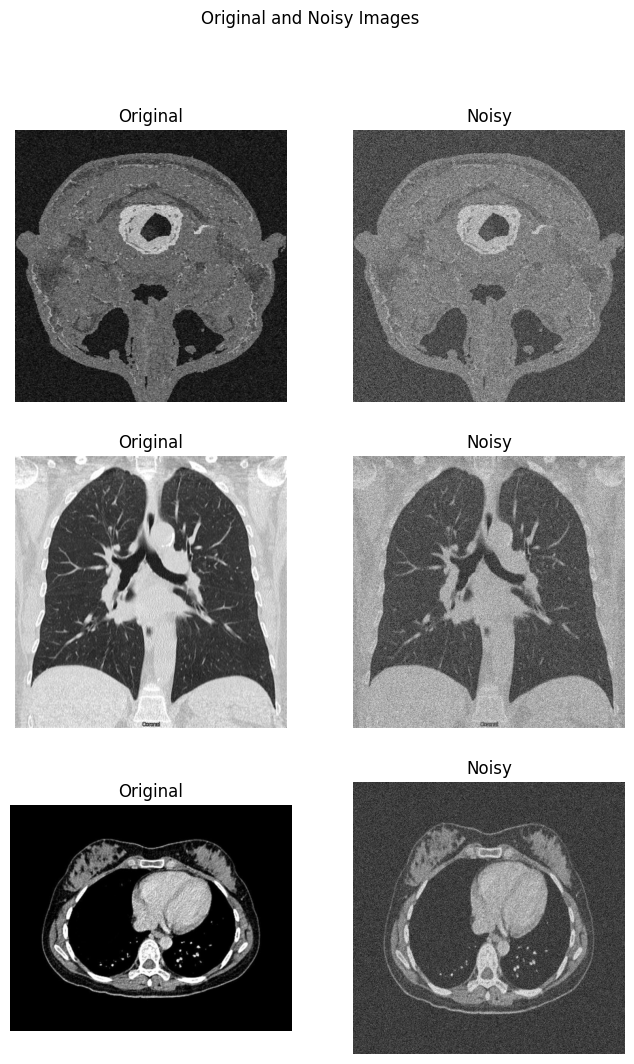

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(8, 12))
fig.suptitle("Original and Noisy Images")

for i, image in enumerate(images):
    axes[i, 0].imshow(image, cmap='gray')
    axes[i, 0].set_title("Original")
    axes[i, 0].axis("off")

    noisy_image = noisy_images[i]
    axes[i, 1].imshow(noisy_image, cmap='gray')
    axes[i, 1].set_title("Noisy")
    axes[i, 1].axis("off")

plt.show()

# Plot denoised images for each iteration

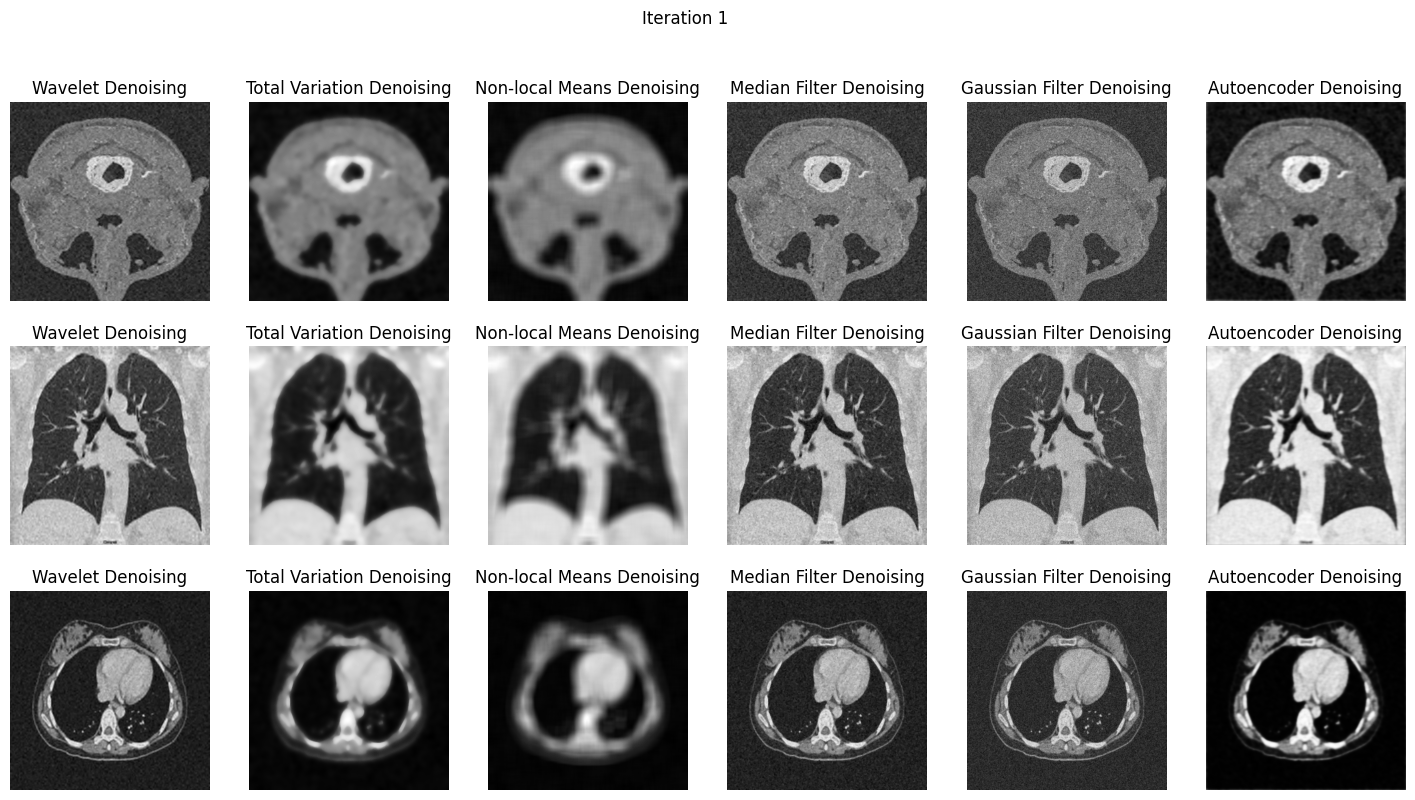

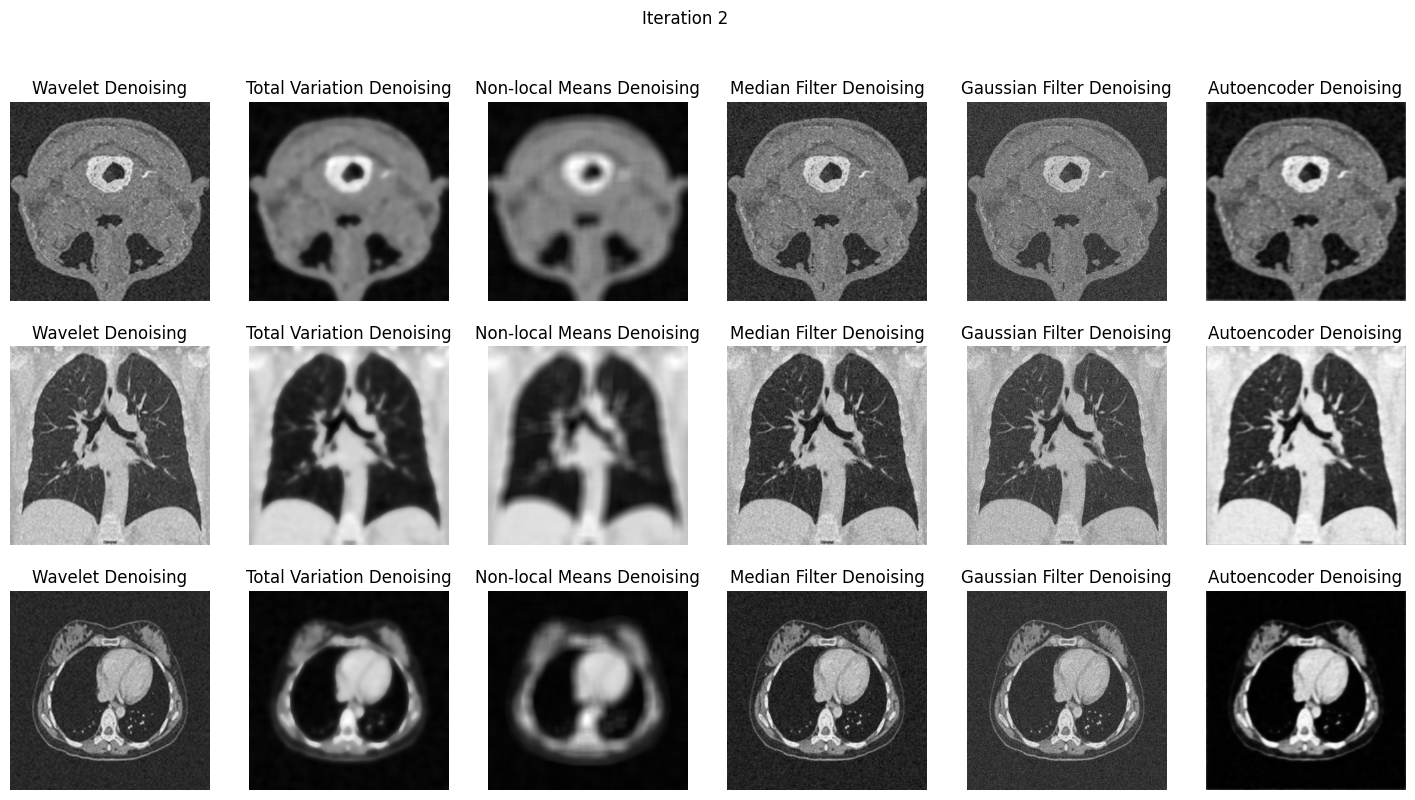

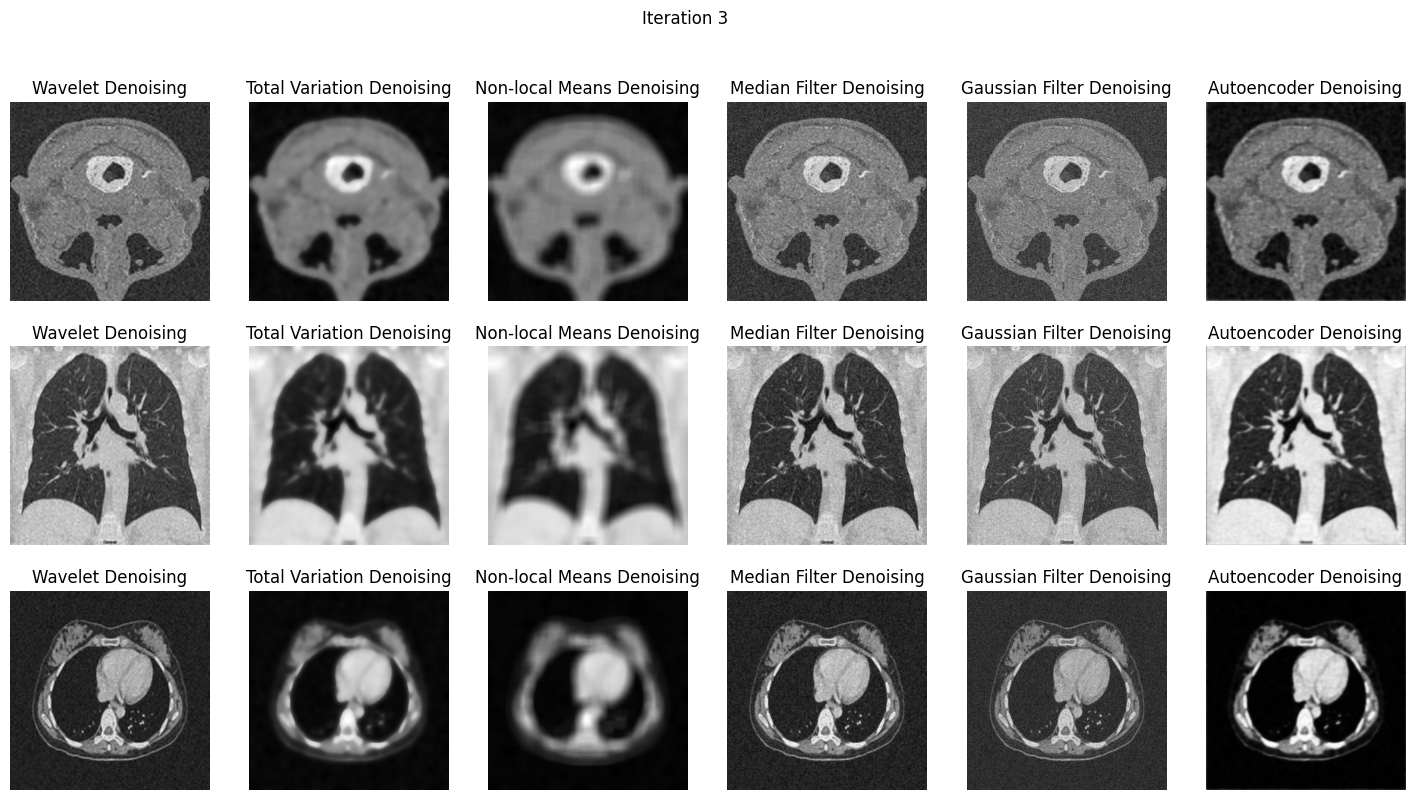

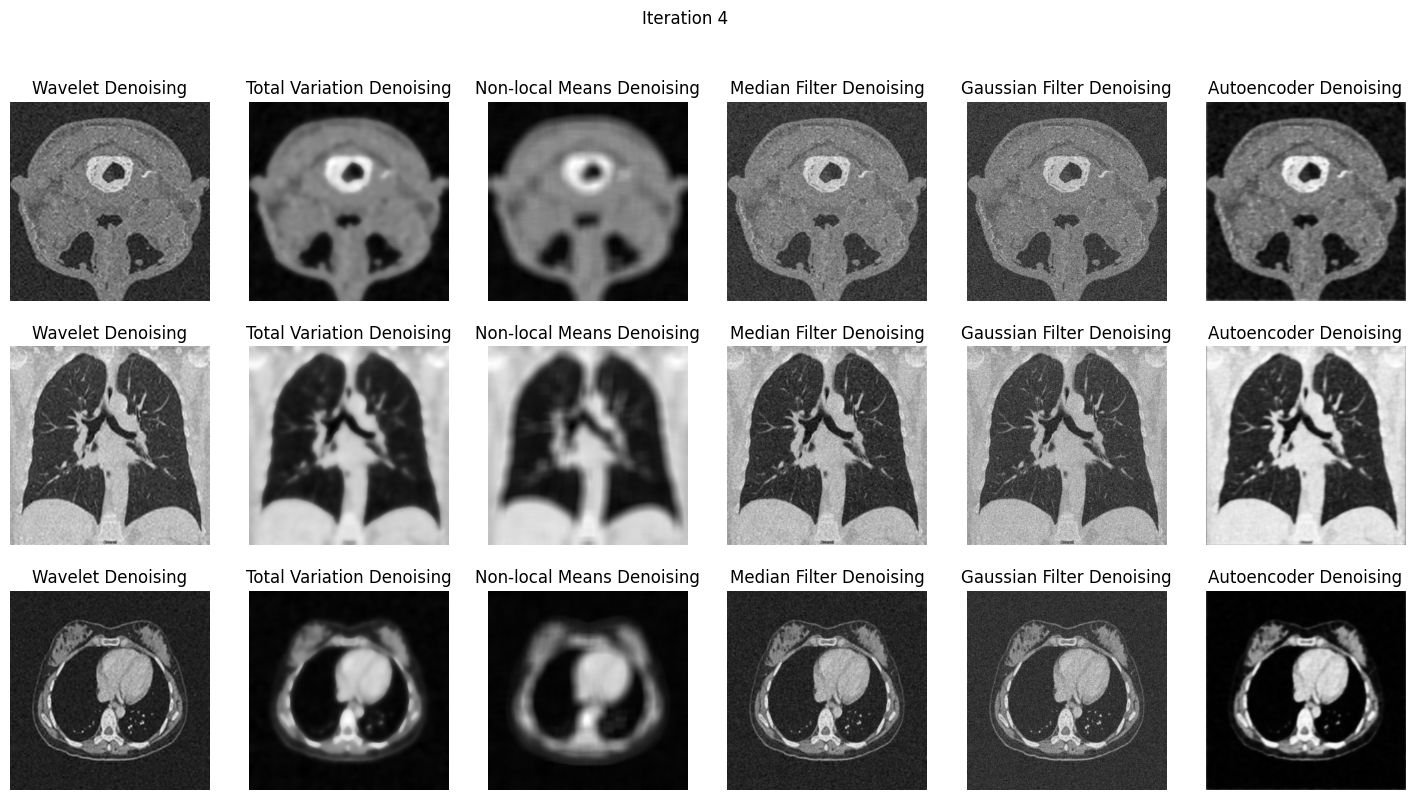

In [16]:
for i in range(num_runs - 1):
    fig, axes = plt.subplots(3, 6, figsize=(18, 9))
    fig.suptitle(f"Iteration {i+1}")

    for j, image in enumerate(images):
        # Wavelet Denoising
        denoised_wavelet = denoised_wavelet_all[i][j]
        axes[j, 0].imshow(denoised_wavelet, cmap='gray')
        axes[j, 0].set_title("Wavelet Denoising")
        axes[j, 0].axis("off")

        # Total Variation Denoising
        denoised_tv = denoised_tv_all[i][j]
        axes[j, 1].imshow(denoised_tv, cmap='gray')
        axes[j, 1].set_title("Total Variation Denoising")
        axes[j, 1].axis("off")

        # Non-local Means Denoising
        denoised_nlmeans = denoised_nlmeans_all[i][j]
        axes[j, 2].imshow(denoised_nlmeans, cmap='gray')
        axes[j, 2].set_title("Non-local Means Denoising")
        axes[j, 2].axis("off")

        # Median Filter Denoising
        denoised_median = denoised_median_all[i][j]
        axes[j, 3].imshow(denoised_median, cmap='gray')
        axes[j, 3].set_title("Median Filter Denoising")
        axes[j, 3].axis("off")

        # Gaussian Filter Denoising
        denoised_gaussian = denoised_gaussian_all[i][j]
        axes[j, 4].imshow(denoised_gaussian, cmap='gray')
        axes[j, 4].set_title("Gaussian Filter Denoising")
        axes[j, 4].axis("off")

        # Autoencoder Denoising
        denoised_autoencoder = denoised_autoencoder_all[i][j].squeeze()
        axes[j, 5].imshow(denoised_autoencoder, cmap='gray')
        axes[j, 5].set_title("Autoencoder Denoising")
        axes[j, 5].axis("off")

    plt.show()